In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import pandas as pd
from scipy.integrate import trapezoid as trapz

In [13]:
from time_vary_and_norm_simulators import psiam_tied_data_gen_wrapper_rate_norm_fn

In [14]:
from time_vary_norm_utils import up_or_down_RTs_fit_fn, up_or_down_RTs_fit_wrt_stim_fn

In [55]:
N_sim = int(1e5)
dt = 1e-4

V_A = 1.6
theta_A = 2.5
t_A_aff = -0.22
# t_A_aff = 0

t_stim = 0.25
rate_lambda = 0.13
T_0 = 0.45 * 1e-3
theta_E = 45

t_E_aff = 0.068
# t_E_aff = 0
del_go = 0.13

rate_norm_l = 0.5

N_print = int(N_sim / 5)

ABL = 20
ILD = 2

Z_E = 1.5


# only norm

In [ ]:
sim_results = Parallel(n_jobs=30)(
    delayed(psiam_tied_data_gen_wrapper_rate_norm_fn)(
        V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, del_go, 
        t_stim, rate_norm_l, iter_num, N_print, dt
    ) for iter_num in tqdm(range(N_sim))
)

In [ ]:
sim_results_df = pd.DataFrame(sim_results)
sim_df_up = sim_results_df[(sim_results_df['choice'] == 1) & (sim_results_df['rt'] > sim_results_df['t_stim'])]
sim_df_down = sim_results_df[(sim_results_df['choice'] == -1) & (sim_results_df['rt'] > sim_results_df['t_stim'])]
sim_rt_up = sim_df_up['rt'] - sim_df_up['t_stim']
sim_rt_down = sim_df_down['rt'] - sim_df_down['t_stim']
total_len = len(sim_rt_up) + len(sim_rt_down)

In [ ]:
bw = 0.02
bins = np.arange(0, 2, bw)
sim_rt_up_hist, _ = np.histogram(sim_rt_up, bins=bins, density=True)
sim_rt_down_hist, _ = np.histogram(sim_rt_down,bins=bins, density=True)
bin_centers = bins[:-1] + 0.5*bw
plt.plot(bin_centers, sim_rt_up_hist * len(sim_rt_up)/total_len)
plt.plot(bin_centers, -sim_rt_down_hist * len(sim_rt_down)/total_len)

plt.plot(t_pts - t_stim, theory_up, ls='--')
plt.plot(t_pts - t_stim, -theory_down, ls='--')

In [ ]:
len(sim_rt_up)/total_len, len(sim_rt_down)/total_len, len(sim_rt_up)/total_len +  len(sim_rt_down)/total_len

In [ ]:
trapz(theory_up, t_pts), trapz(theory_down, t_pts)

# norm & time vary

In [56]:
from time_vary_and_norm_simulators import psiam_tied_data_gen_wrapper_rate_norm_time_vary_fn, phi_t_fn

In [57]:
from types import SimpleNamespace
rate_lambda  = 0.11470
T_0   = 0.67498 * 1e-3
theta_E    = 25.55786
Z_E        = 1.48858
t_E_aff    = 48.77318
rate_norm_l   = 0.03780
bump_height = 0.16210


bump_offset = 0
bump_width = 0.240
dip_width = 0.038
dip_height = 0.327

bump_height = 0.5

phi_params = {
    'h1': bump_width,
    'a1': bump_height,
    'h2': dip_width,
    'a2': dip_height,
    'b1': bump_offset
}

phi_params_obj = SimpleNamespace(**phi_params)

In [58]:
sim_results = Parallel(n_jobs=30)(
    delayed(psiam_tied_data_gen_wrapper_rate_norm_time_vary_fn)(
        V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, del_go, 
        t_stim, rate_norm_l, iter_num, N_print, phi_params_obj, dt
    ) for iter_num in tqdm(range(N_sim))
)

  0%|          | 0/100000 [00:00<?, ?it/s]

os id: 983496, In iter_num: 0, ABL: 20, ILD: 2, t_stim: 0.25
os id: 983507, In iter_num: 20000, ABL: 20, ILD: 2, t_stim: 0.25
os id: 983497, In iter_num: 40000, ABL: 20, ILD: 2, t_stim: 0.25
os id: 983514, In iter_num: 60000, ABL: 20, ILD: 2, t_stim: 0.25
os id: 983497, In iter_num: 80000, ABL: 20, ILD: 2, t_stim: 0.25


In [59]:
sim_results_df = pd.DataFrame(sim_results)
# sim_df_up = sim_results_df[(sim_results_df['choice'] == 1) & (sim_results_df['rt'] > sim_results_df['t_stim'])]
# sim_df_down = sim_results_df[(sim_results_df['choice'] == -1) & (sim_results_df['rt'] > sim_results_df['t_stim'])]
sim_df_up = sim_results_df[(sim_results_df['choice'] == 1) ]
sim_df_down = sim_results_df[(sim_results_df['choice'] == -1) ]

sim_rt_up = sim_df_up['rt'] - sim_df_up['t_stim']
sim_rt_down = sim_df_down['rt'] - sim_df_down['t_stim']
total_len = len(sim_rt_up) + len(sim_rt_down)

In [60]:
# theory
is_norm = True
is_time_vary = True
K_max = 10
t_pts = np.arange(-1, 5, 0.001)
theory_up = np.array([up_or_down_RTs_fit_fn(
                    t, 1,
                    V_A, theta_A, t_A_aff,
                    t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
                    phi_params_obj, rate_norm_l, 
                    is_norm, is_time_vary, K_max) for t in t_pts])

theory_down = np.array([up_or_down_RTs_fit_fn(
                    t, -1,
                    V_A, theta_A, t_A_aff,
                    t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
                    phi_params_obj, rate_norm_l, 
                    is_norm, is_time_vary, K_max) for t in t_pts])

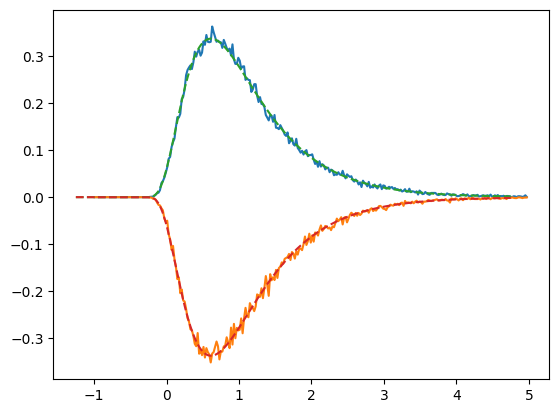

In [61]:
bw = 0.02
bins = np.arange(-1, 5, bw)
sim_rt_up_hist, _ = np.histogram(sim_rt_up, bins=bins, density=True)
sim_rt_down_hist, _ = np.histogram(sim_rt_down,bins=bins, density=True)
bin_centers = bins[:-1] + 0.5*bw
plt.plot(bin_centers, sim_rt_up_hist * len(sim_rt_up)/total_len)
plt.plot(bin_centers, -sim_rt_down_hist * len(sim_rt_down)/total_len)

plt.plot(t_pts - t_stim, theory_up, ls='--')
plt.plot(t_pts - t_stim, -theory_down, ls='--')

In [51]:
from time_vary_norm_utils import rho_A_t_VEC_fn
from scipy.integrate import cumulative_trapezoid as cumtrapz

N_theory = int(1e3)
pdf = rho_A_t_VEC_fn(t_pts - t_A_aff + t_stim, V_A, theta_A)

P_A_samples_mean =  pdf
C_A_mean = cumtrapz(P_A_samples_mean, t_pts, initial=0)

In [52]:
up_theory_2 = np.zeros_like(t_pts)
down_theory_2 = np.zeros_like(t_pts)
for idx, t in enumerate(t_pts):
    P_A = P_A_samples_mean[idx]
    C_A = C_A_mean[idx]
    up_theory_2[idx] = up_or_down_RTs_fit_wrt_stim_fn(
        t, 1,
        P_A, C_A,
        t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
        phi_params_obj, rate_norm_l,
        is_norm, is_time_vary, K_max)

    down_theory_2[idx] = up_or_down_RTs_fit_wrt_stim_fn(
        t, -1,
        P_A, C_A,
        t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
        phi_params_obj, rate_norm_l,
        is_norm, is_time_vary, K_max)

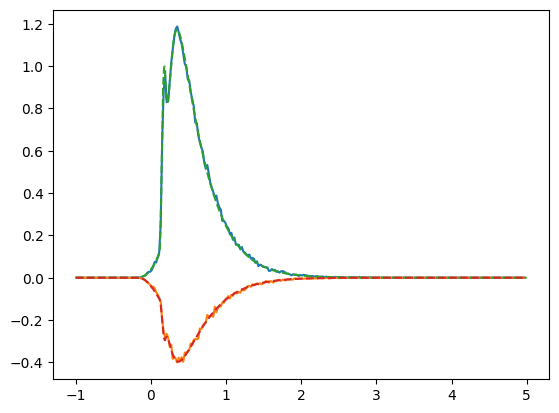

In [53]:
bw = 0.02
bins = np.arange(-1, 5, bw)
sim_rt_up_hist, _ = np.histogram(sim_rt_up, bins=bins, density=True)
sim_rt_down_hist, _ = np.histogram(sim_rt_down,bins=bins, density=True)
bin_centers = bins[:-1] + 0.5*bw
plt.plot(bin_centers, sim_rt_up_hist * len(sim_rt_up)/total_len)
plt.plot(bin_centers, -sim_rt_down_hist * len(sim_rt_down)/total_len)

plt.plot(t_pts, up_theory_2, ls='--')
plt.plot(t_pts, -down_theory_2, ls='--')

# check cdf?

In [17]:
from time_vary_norm_utils import cum_pro_and_reactive_time_vary_fn

In [34]:
tpts2 = np.arange(0, 5, 0.02)
cdf_theory = np.array([cum_pro_and_reactive_time_vary_fn(
                            t,
                            V_A, theta_A, t_A_aff,
                            t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff,
                            phi_params_obj, rate_norm_l, 
                            is_norm, is_time_vary, K_max) for t in tpts2])

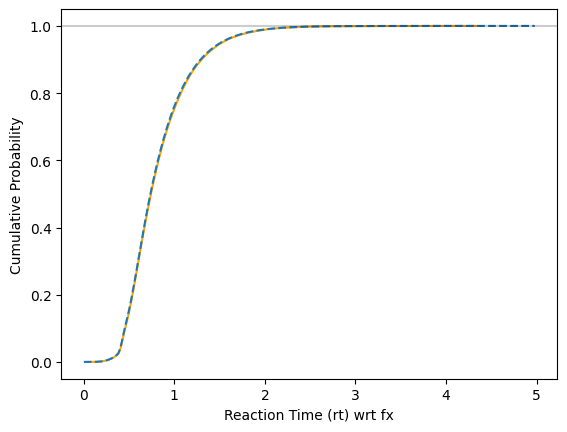

In [40]:
import numpy as np
import matplotlib.pyplot as plt

rt_values = np.sort(sim_results_df['rt'])
cdf = np.linspace(0, 1, len(rt_values))

plt.figure()
plt.plot(rt_values, cdf, label='Empirical CDF', color='orange')
plt.xlabel('Reaction Time (rt) wrt fx')
plt.ylabel('Cumulative Probability')



plt.plot(tpts2, cdf_theory, ls='--')
plt.axhline(1, alpha=0.2, color='k')